# Notebook for functional clustering

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skfda.ml.clustering import KMeans
from sklearn.preprocessing import minmax_scale

from skfda.representation.grid import FDataGrid

## Files Reading

In [2]:
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

# ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
#     y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# ds2 = ds2.isel(time_counter = (np.arange(0, len(ds2.time_counter),2)), 
#     y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
#     x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

## Functions

In [3]:
def func_clust_drivers(dataset, dataset2, name):

    input = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        ])

    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(input[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880))) # input[1] because this variable is down to 100m
    input =input[:,:,indx[0]]

    input = np.transpose(input,axes=(0,2,1)) # this is the right shape for preprocessing the data

    # Transforming each variable individually
    input[0] = minmax_scale(input[0])
    input[1] = minmax_scale(input[1])
    input[2] = minmax_scale(input[2])
    input[3] = minmax_scale(input[3])
    input[4] = minmax_scale(input[4])
    input[5] = minmax_scale(input[5])
    input[6] = minmax_scale(input[6])

    # Converting it to an appropriate format for functional clustering
    input = np.transpose(input,axes=(1,2,0)) # this is the right shape for converting it to a functional variable
    input2 = FDataGrid(input, np.arange(0,len(dataset.time_counter)))

    # Training
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(input2)
    clusters = kmeans.predict(input2)

    # Creating the map
    indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
    indx2[indx[0]] = clusters
    clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

    # Preparation of the dataarray 
    clusters2 = xr.DataArray(clusters,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed functional analysis algorithm",
        long_name ="Cluster",
        units="count"),)
    
    # Plotting
    clusters2.plot()
    plt.title('Functional Clustering for drivers')

    return(clusters)


In [4]:
def func_clust_target(dataset, name):

    input = np.reshape(np.ravel(dataset[name]), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))

    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(input).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
    input = input[:, indx[0]]

    input = input.transpose()
    input = minmax_scale(input)

    # Converting it to an appropriate format for functional clustering
    input2 = FDataGrid(input)

    # Training
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(input2)
    clusters = kmeans.predict(input2)

    # Creating the map
    indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
    indx2[indx[0]] = clusters
    clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

    # Preparation of the dataarray 
    clusters2 = xr.DataArray(clusters,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed functional analysis algorithm",
        long_name ="Cluster",
        units="count"),)
    
    # Plotting
    clusters2.plot()
    plt.title('Functional Clustering for '+ name)

    return(clusters)


## Plotting

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

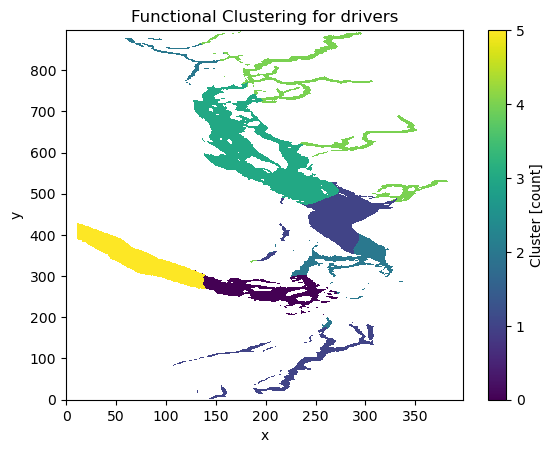

In [5]:
func_clust_drivers(dataset, dataset2,'drivers')

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

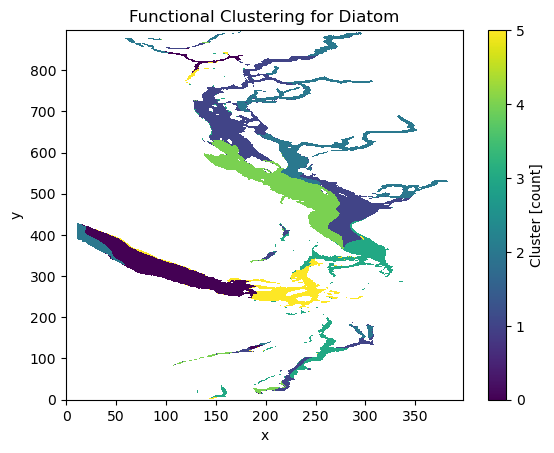

In [7]:
func_clust_target(dataset, 'Diatom')

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

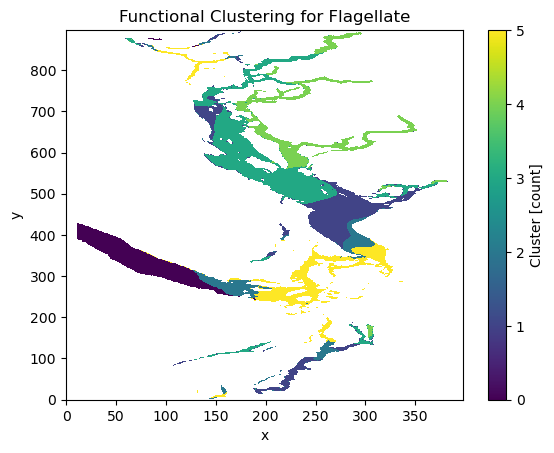

In [8]:
func_clust_target(dataset, 'Flagellate')

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

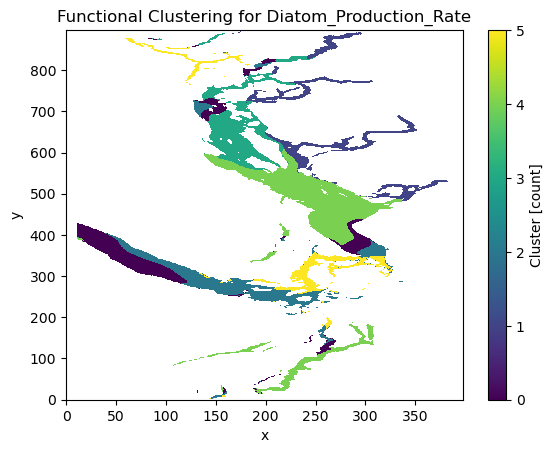

In [10]:
func_clust_target(dataset, 'Diatom_Production_Rate')

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

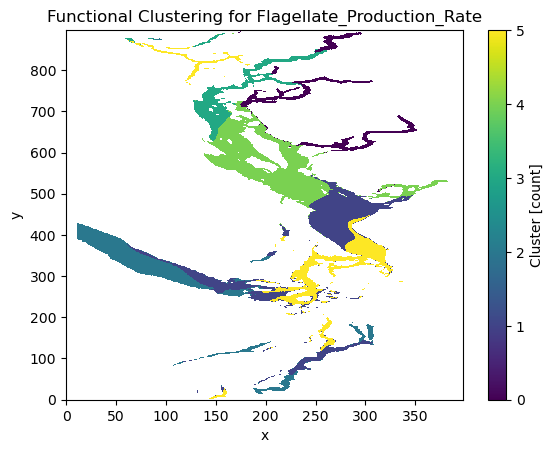

In [9]:
func_clust_target(dataset, 'Flagellate_Production_Rate')